#### Clone the DoDUO repository, fetch the data , install the packages

In [ ]:
!git clone https://github.com/megagonlabs/doduo

Cloning into 'doduo'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 18), reused 37 (delta 8), pack-reused 0
Unpacking objects: 100% (55/55), 42.06 KiB | 1.45 MiB/s, done.


In [ ]:
%cd doduo

/content/doduo


In [ ]:
!bash download.sh

--2023-05-29 10:24:47--  https://doduo-data.s3-us-west-2.amazonaws.com/data.tar.gz
Resolving doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)... 3.5.84.14, 3.5.79.148, 52.218.153.185, ...
Connecting to doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)|3.5.84.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106987437 (102M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 102.03M  17.7MB/s    in 7.0s    

2023-05-29 10:24:54 (14.6 MB/s) - ‘data.tar.gz’ saved [106987437/106987437]

./._data
./data/
./data/._msato_cv_4.csv
./data/msato_cv_4.csv
./data/._msato_cv_2.csv
./data/msato_cv_2.csv
./data/._msato_cv_3.csv
./data/msato_cv_3.csv
./data/._msato_cv_1.csv
./data/msato_cv_1.csv
./data/._msato_cv_0.csv
./data/msato_cv_0.csv
./data/._table_col_type_serialized.pkl
./data/table_col_type_serialized.pkl
./data/._sato_cv_3.csv
./data/sato_cv_3.csv
./data/._sato_cv_2

In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00


#### Import Modules

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import re
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report
)

from transformers import (
    T5Tokenizer,
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)

from transformers.models.auto.processing_auto import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from pandas.errors import SettingWithCopyWarning
import random
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import locale
locale.getpreferredencoding = lambda: "UTF-8"


##### Preprocessing Functions

In [ ]:
def create_map_dict_for_labels(temp_df):
  '''
  Create dictionaries to map the values with labels
  '''

  # Create an instance of MultiLabelBinarizer
  mlb = MultiLabelBinarizer()
  # Fit the MultiLabelBinarizer to the data and transform the column of lists
  one_hot = pd.DataFrame(mlb.fit_transform(temp_df['labels']), columns=mlb.classes_, index=temp_df.index)

  my_dict= {}
  for i,l in enumerate(one_hot.columns):
    my_dict[i]= l

  my_inv_dict = {v: k for k, v in my_dict.items()}

  return my_dict , my_inv_dict

def given_list(temp,my_inv_dict):
  new_list = []
  for t in temp:
    new_list.append(str(my_inv_dict.get(t)))
  return new_list

def mul_given_list(temp,my_inv_dict):
  '''
  Replace the original value of the label
  with the (int) value from the my_inv_dict dictionary
  '''
  new_list = []
  for t in temp:
    if t in my_inv_dict.keys():
      new_list.append(str(my_inv_dict.get(t)))
    else:
      new_list.append(t)
  return ' '.join(new_list)

def flatten_tablewise_df_tolist(train_df,val_df):
  '''
  With respect to the dataframes, flatten the values to list
  as well as utilize necessary preprocessing actions

  '''
  grouped_df_train_data = []
  grouped_df_val_data = []

  grouped_df_train_labels = []
  grouped_df_val_labels = []

  token_grouped_df_train_labels = []
  token_grouped_df_val_labels = []

  token_grouped_df_train_data =[]
  token_grouped_df_val_data = []

  train_label_list = []
  val_label_list = []
  train_data_list = []
  val_data_list = []

  for (index, group_df) in train_df.groupby('table_id'):
    grouped_df_train_data.append(' </s> '.join(group_df.data.values.tolist()))
    grouped_df_train_labels.append(group_df.new_labels.tolist())
  for (index, group_df) in val_df.groupby('table_id'):
    grouped_df_val_data.append(' </s> '.join(group_df.data.values.tolist()))
    grouped_df_val_labels.append(group_df.new_labels.tolist())

  for g in grouped_df_train_data:
    token_grouped_df_train_data.append(g + ' </s> ')
  for g in grouped_df_val_data:
    token_grouped_df_val_data.append(g + ' </s> ')
  for g in grouped_df_train_labels:
    token_grouped_df_train_labels.append(' </s> '.join(g) + ' </s> ')
  for g in grouped_df_val_labels:
    token_grouped_df_val_labels.append(' </s> '.join(g) +  ' </s> ')


  for t in token_grouped_df_train_labels:
    split_list = t.split(' ')
    train_label_list.append(mul_given_list(split_list,my_inv_dict))
  for t in token_grouped_df_val_labels:
    split_list = t.split(' ')
    val_label_list.append(mul_given_list(split_list,my_inv_dict))

  for t in token_grouped_df_train_data:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    train_data_list.append('multilabel classification: ' + texty)
  for t in token_grouped_df_val_data:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    val_data_list.append('multilabel classification: ' + texty)

  return train_label_list, val_label_list, train_data_list, val_data_list




##### Preprocessing Classes

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()
        self.SEED = 42
        self.MODEL_PATH = 't5-base'
        self.TOKENIZER = T5Tokenizer.from_pretrained('google/mt5-small')
        self.SRC_MAX_LENGTH = 180
        self.TGT_MAX_LENGTH = 50
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 2e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.OUTPUT_PATH = '/content/T5model_tablewise_annotation.pt'
        self.EPOCHS = 10

In [ ]:
class T5Dataset(Dataset):
    def __init__(self, texts,labels):
        super(T5Dataset, self).__init__()
        self.texts = texts
        self.labels = labels
        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        tgt_tokenized = self.tokenizer.encode_plus(
            self.labels[index],
            max_length=self.tgt_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
        tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long(),
            'tgt_input_ids': tgt_input_ids.long(),
            'tgt_attention_mask': tgt_attention_mask.long()
        }



#### Data Preprocessing

In [ ]:
config = Config()

# load the data
with open('/content/doduo/data/table_col_type_serialized.pkl', 'rb') as f:
    all_data = pickle.load(f)

In [ ]:
# define a threshold for the training & validation data
train_data_threshold = 150000
validation_data_threshold = 3000


train_df = all_data.get('train').head(train_data_threshold)
val_df = all_data.get('dev').head(validation_data_threshold)
whole_df = all_data.get('train')

In [ ]:
# create a dictionary (and inverse) with respect to labels of df
my_dict , my_inv_dict = create_map_dict_for_labels(whole_df)

for key,value in my_dict.items():
  print(key , value)

0 american_football.football_coach
1 american_football.football_conference
2 american_football.football_player
3 american_football.football_team
4 amusement_parks.park
5 amusement_parks.ride
6 architecture.architectural_structure_owner
7 architecture.building
8 architecture.structure
9 architecture.venue
10 astronomy.asteroid
11 astronomy.astronomical_discovery
12 astronomy.celestial_object
13 astronomy.constellation
14 astronomy.orbital_relationship
15 astronomy.star_system_body
16 automotive.company
17 automotive.model
18 aviation.aircraft_model
19 aviation.aircraft_owner
20 aviation.airline
21 aviation.airport
22 award.award
23 award.award_category
24 award.award_ceremony
25 award.award_discipline
26 award.award_presenting_organization
27 award.competition
28 award.hall_of_fame_inductee
29 award.recurring_competition
30 baseball.baseball_league
31 baseball.baseball_player
32 baseball.baseball_position
33 baseball.baseball_team
34 basketball.basketball_coach
35 basketball.basketball_

In [ ]:
# create new column of new_labels which is based to stringfy the values of the column labels
train_df['new_labels'] = train_df['labels'].apply(lambda x:  ' , '.join(x))
val_df['new_labels'] = val_df['labels'].apply(lambda x:  ' , '.join(x))

train_label_list, val_label_list, train_data_list, val_data_list =  flatten_tablewise_df_tolist(train_df,val_df)

print('Length of training-data list : {}'.format(len(train_data_list)))
print('Length of training-label list : {}'.format(len(train_label_list)))

print('Length of validation-data list : {}'.format(len(val_data_list)))
print('Length of validation-label list : {}'.format(len(val_label_list)))

Length of training-data list : 95137
Length of training-label list : 95137
Length of validation-data list : 1091
Length of validation-label list : 1091


In [ ]:
# Initiate T5Datasets as well as Dataloader with respect to data & label lists

train_data = T5Dataset(texts=train_data_list, labels=train_label_list)
train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)

val_data = T5Dataset(texts=val_data_list, labels=val_label_list)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

##### Example of the Dataset

In [ ]:
train_df.head()

,table_id,labels,data,label_ids,new_labels
0,2728176-1,[organization.organization],Public Against Violence Christian Democratic M...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",organization.organization
1,2728185-1,"[government.political_party, organization.orga...",Communist Party of Czechoslovakia Czech Nation...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","government.political_party , organization.orga..."
2,27282030-1,"[sports.sports_team, soccer.football_team, org...",North Hobart Glenorchy Clarence Sandy Bay Hoba...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","sports.sports_team , soccer.football_team , or..."
3,2728219-1,"[location.administrative_division, location.lo...",Atlantic Bergen Burlington Camden Cape May Cum...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","location.administrative_division , location.lo..."
4,2728231-1,[film.film],Bottle Rocket Rushmore The Royal Tenenbaums Bo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",film.film


In [ ]:
train_df[train_df.table_id.str.contains('9999731-2')]

,table_id,labels,data,label_ids,new_labels
23719,9999731-2,"[location.citytown, location.location, locatio...",Fountain City Fountain City Frankton Gaston,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","location.citytown , location.location , locati..."
23720,9999731-2,"[location.administrative_division, location.lo...",89 Wayne 89 Wayne 48 Madison 18 Delaware,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","location.administrative_division , location.lo..."
23721,9999731-2,"[sports.sports_league, organization.organization]",Tri-Eastern White River White River,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","sports.sports_league , organization.organization"


In [ ]:
train_data_list[-1]

'multilabel classification: fountain city fountain city frankton gaston </s> 89 wayne 89 wayne 48 madison 18 delaware </s> tri-eastern white river white river </s> '

In [ ]:
train_label_list[-1]

'139 , 145 , 141 </s> 135 , 145 , 150 </s> 227 , 191 </s> '

In [ ]:
config.TOKENIZER.decode(train_data[-1].get('src_input_ids'))

'multilabel classification: fountain city fountain city frankton gaston</s> 89 wayne 89 wayne 48 madison 18 delaware</s> tri-eastern white river white river</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

#### Data Visualizations

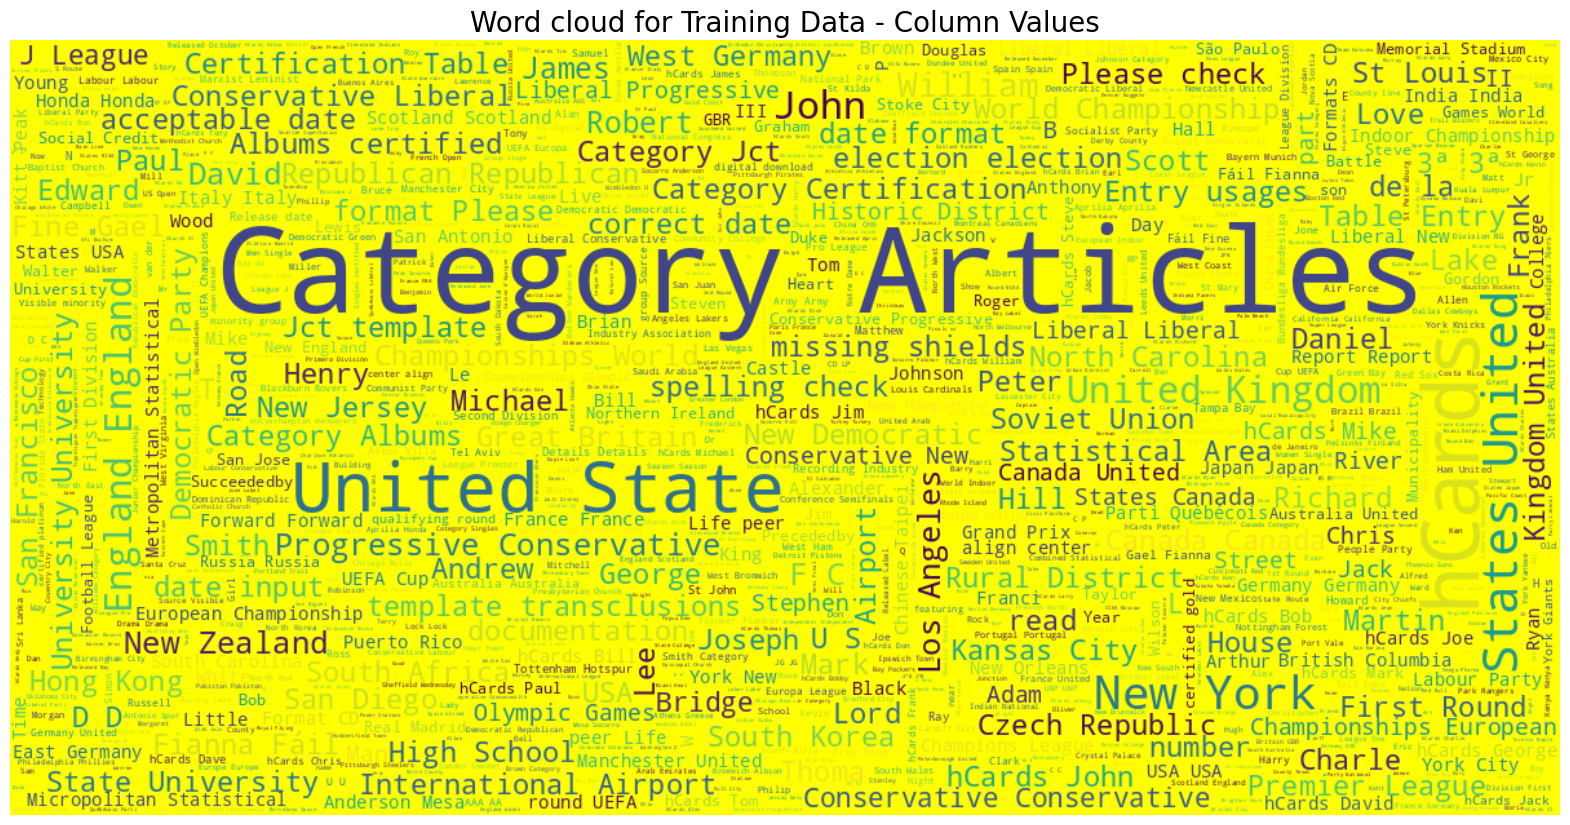

In [ ]:
# WordCloud

train_data_ex = train_df['data']
train_data_ex_string = ' '.join(train_data_ex)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="yellow",stopwords=STOPWORDS).generate(train_data_ex_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Training Data - Column Values',fontsize = 20)
plt.show()


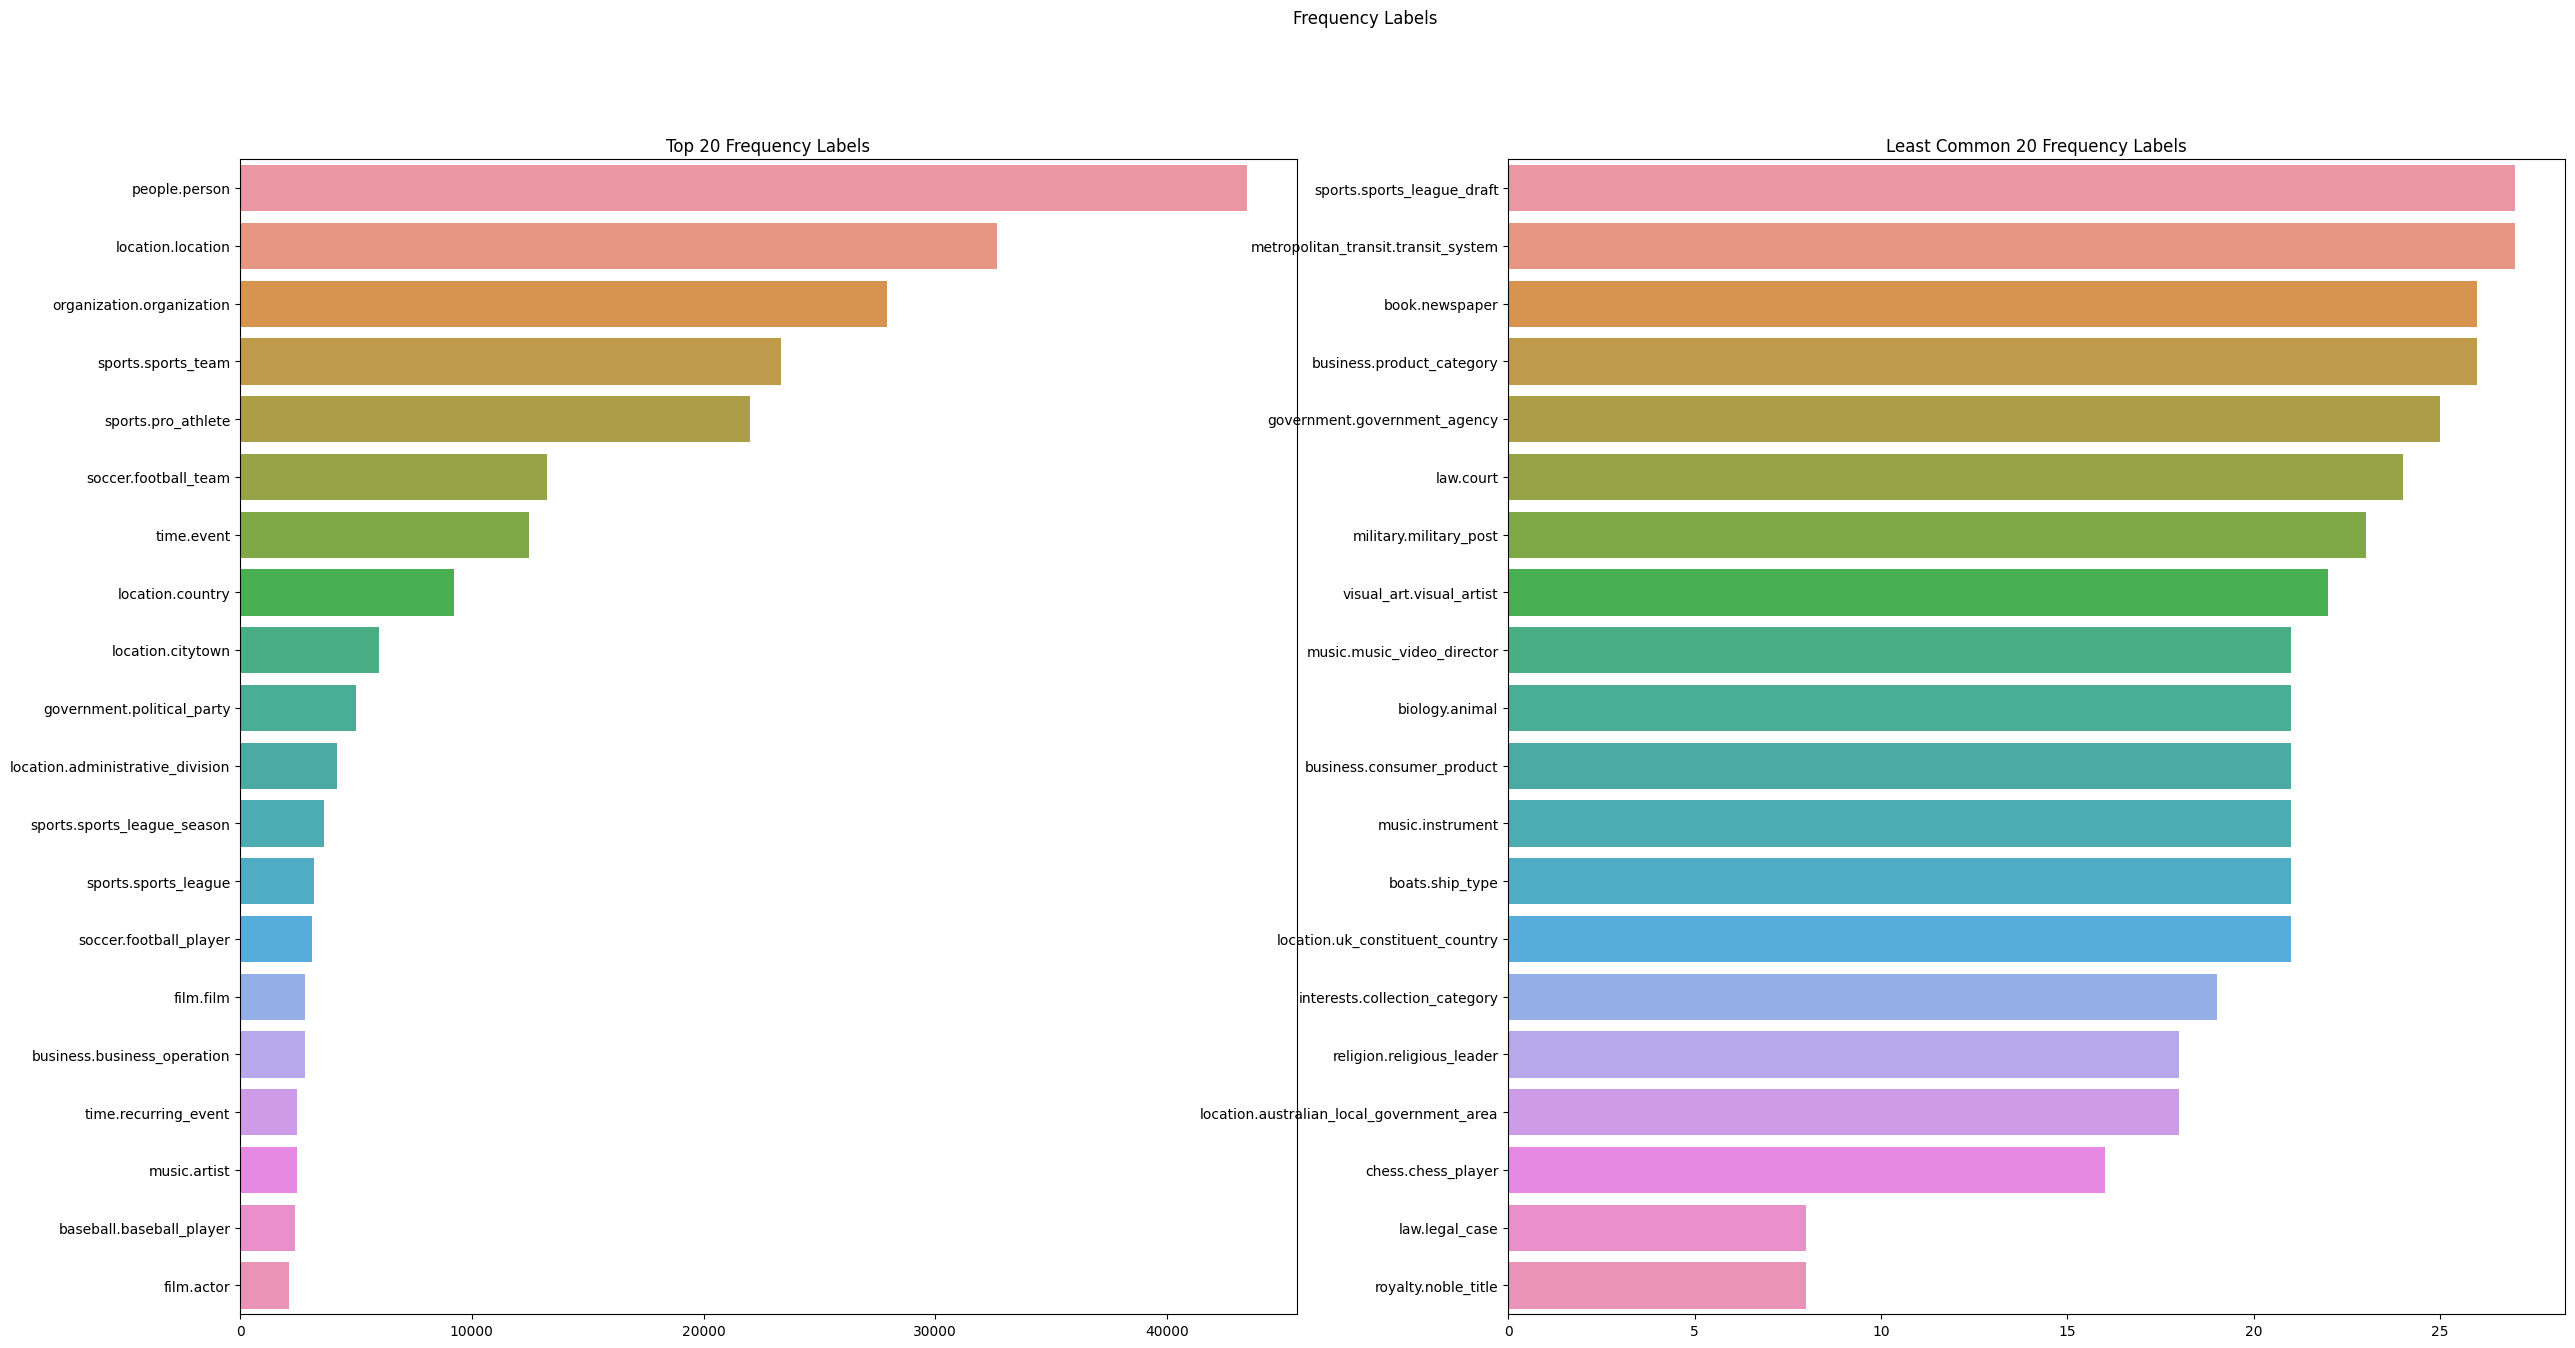

In [ ]:
# Frequency Labels - Visualization

train_df_value_counts = pd.Series([x for item in train_df.labels for x in item]).value_counts()


fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))

sns.barplot(y=train_df_value_counts.head(20).index, x=train_df_value_counts.head(20).values,ax=ax1)
sns.barplot(y=train_df_value_counts.tail(20).index, x=train_df_value_counts.tail(20).values,ax=ax2)

ax1.set_title('Top 20 Frequency Labels')
ax2.set_title('Least Common 20 Frequency Labels')
fig.suptitle('Frequency Labels')
plt.show()

##### Tokenizer Length Distribution

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


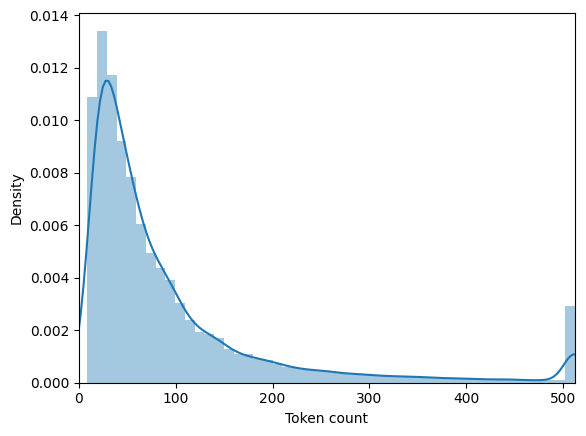

In [ ]:
tmp_tokenizer = config.TOKENIZER

token_lens = []

for txt in train_data_list:
  tokens = tmp_tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

#### T5 Training

##### Training Classes

In [ ]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()
        self.t5_model = T5ForConditionalGeneration.from_pretrained('google/mt5-small')

    def forward(
        self,
        input_ids,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

##### Training Functions

In [ ]:
def convert_to_ohe(temp_list):
  '''
  Convert predicted list , with target values, to
  one-hot-encoding according to the dict-key-values
  in order to calculate evaluation metrics
  NOTE that the number of classes is 255
  '''
  global_list = []
  for temp_batch in temp_list:
    base = 255*[0]
    temp_list_decomp= temp_batch.split(' ')
    for l in temp_list_decomp:
      if l is None or l.strip() =='':
        continue
      else:
        temp = l.strip()
      if int(temp) in my_dict.keys():
        base[ int(temp) ] = 1
      else:
        continue
    global_list.append(base)
  return np.array(global_list)


In [ ]:
def val(model, val_dataloader, criterion):
    '''
    The function that is utilized to the validation phase
    with th respective dataloader
    '''

    val_loss = 0
    true, pred = [], []

    # set model.eval() every time during evaluation
    model.eval()

    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        b_tgt_input_ids = batch['tgt_input_ids']
        lm_labels = b_tgt_input_ids.to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids,
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id,skip_special_tokens=True).replace(",", "")
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids,
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True).replace(",", "")
                pred.append(pred_decoded)

    true_ohe = convert_to_ohe(true)
    pred_ohe = convert_to_ohe(pred)

    # for Debugging
    # print('******'*8)
    # print(set(pred))
    # print('******'*8)


    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score , avg_val_loss


def train(
    model,
    train_dataloader,
    criterion,
    optimizer,
    scheduler,
    epoch
    ):
    '''
    The function that is utilized to the training phase
    with th respective dataloader
    '''

    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()

        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        lm_labels = batch['tgt_input_ids'].to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids,
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # update scheduler
        scheduler.step()


    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)
    return model , avg_train_loss

In [ ]:
# define the model
# and move from CPU to GPU

device = config.DEVICE
model = T5Model()
model.to(device);

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
# define the parameters to be optmized
torch.manual_seed(config.SEED)
criterion = nn.BCEWithLogitsLoss()

if config.FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

num_training_steps = len(train_dataloader) * config.EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
avg_train_loss_list = []
avg_val_loss_list = []

# set the max val F1-score
max_val_micro_f1_score = float('-inf')

# run across the Epochs
for epoch in range(config.EPOCHS):
    model , avg_train_loss = train(model, train_dataloader, criterion, optimizer, scheduler, epoch)
    val_micro_f1_score , avg_val_loss = val(model, val_dataloader, criterion)
    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)
    if config.SAVE_BEST_ONLY:
        # save and overwrite only the best model
        # with the highest F1 score in validation
        if val_micro_f1_score > max_val_micro_f1_score:
            max_val_micro_f1_score = val_micro_f1_score
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(),config.OUTPUT_PATH)
            print(f'Best F1-score in Validation : {max_val_micro_f1_score}')


Epoch 0:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 5.061931584529643
Val loss: 1.7735027092090552
Val accuracy: 0.013748854262144821
Val micro f1 score: 0.19429676172063798
Best F1-score in Validation : 0.19429676172063798


Epoch 1:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 1.7899671388169547
Val loss: 1.4243132307909536
Val accuracy: 0.01833180568285976
Val micro f1 score: 0.2439678284182306
Best F1-score in Validation : 0.2439678284182306


Epoch 2:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 1.3693604753441182
Val loss: 1.2003942572552224
Val accuracy: 0.02474793767186068
Val micro f1 score: 0.24179149644424267


Epoch 3:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 1.1408320563329013
Val loss: 1.0151497488436492
Val accuracy: 0.06691109074243813
Val micro f1 score: 0.3596254562767815
Best F1-score in Validation : 0.3596254562767815


Epoch 4:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 0.9401146827398107
Val loss: 0.8841673606547756
Val accuracy: 0.08615948670944087
Val micro f1 score: 0.4072223117846203
Best F1-score in Validation : 0.4072223117846203


Epoch 5:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 0.8230070960677425
Val loss: 0.7910755825215492
Val accuracy: 0.09074243813015583
Val micro f1 score: 0.43516129032258066
Best F1-score in Validation : 0.43516129032258066


Epoch 6:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 0.7479318560703859
Val loss: 0.7341001888980037
Val accuracy: 0.0999083409715857
Val micro f1 score: 0.4523733673144313
Best F1-score in Validation : 0.4523733673144313


Epoch 7:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 0.6996583150131577
Val loss: 0.7010014381097711
Val accuracy: 0.0999083409715857
Val micro f1 score: 0.4581622987053995
Best F1-score in Validation : 0.4581622987053995


Epoch 8:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 0.6720334535135933
Val loss: 0.6819133790938751
Val accuracy: 0.1008249312557287
Val micro f1 score: 0.45814283462084193


Epoch 9:   0%|          | 0/5947 [00:00<?, ?it/s]

Training loss: 0.6599520045889024
Val loss: 0.6791582880676656
Val accuracy: 0.10815765352887259
Val micro f1 score: 0.46665625488052476
Best F1-score in Validation : 0.46665625488052476


##### Training Graph of the model

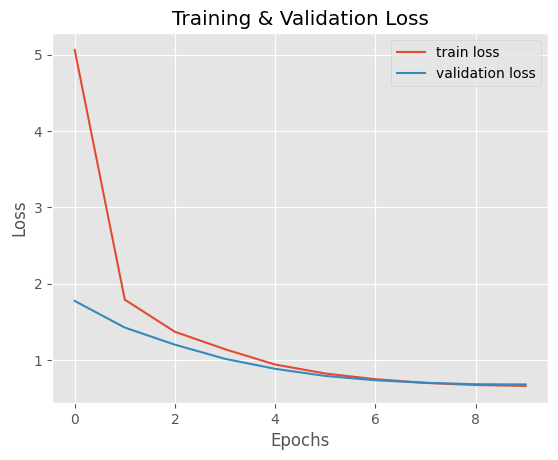

<Figure size 2000x2000 with 0 Axes>

In [ ]:
N = config.EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), avg_train_loss_list, label="train loss")
plt.plot(np.arange(0, N), avg_val_loss_list, label="validation loss")

plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (20,20))
plt.show()

##### Save the Model to Drive

In [ ]:
! cp -r /content/T5model_tablewise_annotation.pt /content/drive/MyDrive/'Colab Notebooks'/Databases/T5_models

#### Loading the Model & Inference Examples

In [ ]:
load_T5_model = T5Model()
load_T5_model.to(config.DEVICE);
load_T5_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Databases/T5_models/T5model_tablewise_annotation.pt'))

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


<All keys matched successfully>

In [ ]:
inference_val_dataloader = DataLoader(val_data, batch_size=1)

#### Inference Functions

In [ ]:
def convert_to_true_labels(inv_dict_labels):
  '''
  Convert from inv-dict labels to
  true labels
  '''
  gen = []
  inv_dict_labels_list = inv_dict_labels.split(' ')
  for l in inv_dict_labels_list:
    if l is not None or l != '':
      if int(l) in my_dict.keys():
        gen.append(my_dict.get(int(l)))
  return ' & '.join(gen)

def inference_single_example(temp_model,temp_batch):
  '''
  With respect to a model and batch we make inference for a single example
  '''

  b_src_input_ids = temp_batch['src_input_ids'].to(config.DEVICE)
  b_src_attention_mask = temp_batch['src_attention_mask'].to(config.DEVICE)
  pred_ids = temp_model.t5_model.generate(
                input_ids=b_src_input_ids,
                attention_mask=b_src_attention_mask
            )

  pred_ids = pred_ids.cpu().numpy()
  for pred_id in pred_ids:
      pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True).replace(",", "")

  return pred_decoded

#### Inference for certain examples of the Validation Dataloader

In [ ]:
# Generate 2 random int for examples
random_list = random.sample(range(1, 1000), 2)
print('Generate random indexes {} '.format(random_list))
print()

counter =0
for index, batch in enumerate(inference_val_dataloader):
  if index in random_list:
    print('Example {}'.format(counter))
    print('Data : {}'.format(config.TOKENIZER.decode(batch.get('src_input_ids')[0],skip_special_tokens=True)))
    inv_dict_labels = config.TOKENIZER.decode(batch.get('tgt_input_ids')[0],skip_special_tokens=True).replace(",", "")
    print('True Inv-Dict Labels : {}'.format(config.TOKENIZER.decode(batch.get('tgt_input_ids')[0],skip_special_tokens=True).replace(",", "")))
    print('True Labels : {}'.format(convert_to_true_labels(inv_dict_labels)))

    inference_ex_labels = inference_single_example(temp_model=load_T5_model,temp_batch=batch)
    print('Predicted Inv-Dict Labels : {}'.format(inference_ex_labels))
    print('Predicted Labels : {}'.format(convert_to_true_labels(inference_ex_labels)))

    print()
    counter = counter +1

Generate random indexes [572, 874] 

Example 0
Data : multilabel classification: oh jae-seok yun suk-young kim young-gwon kim kee-hee ki sung-yeung kim bo-kyung baek sung-dong ji dong-won men's 10 m air pistol women's team men's 81 kg women's 25 m pistol men's 90 kg women's sabre women's individual men's individual men's team sabre men's 50 m pistol men's vault men's greco-roman 66 kg women's 67kg men's 400 m freestyle men's 200 m freestyle women's team épée men's 50 m pistol men's 50 m rifle 3 positions men's team men's 58 kg men's lightweight men's team men's 66 kg men's
True Inv-Dict Labels : 218 208 194 187 238
True Labels : sports.pro_athlete & soccer.football_player & people.person & olympics.olympic_event_competition & time.event
Predicted Inv-Dict Labels : 218 194
Predicted Labels : sports.pro_athlete & people.person

Example 1
Data : multilabel classification: aek fc akademik sofia sv austria salzburg fc barcelona fc basel eintracht braunschweig hibernian f.c. fc wacker innsbr